# Purpose Statement

This Notebook Introduces how to download our Benchmark datasets and a single benchmark method for post-processing an Ensemble forecast (EMOS), it corrects the forecast of the PNA from multiple modeling centers. Please see their paper for an exploration of the EMOS system we use here, and other interesting methods for post-process bench marking. A brief description is also below:


#### Ensemble Model Output Statistics (EMOS)

---
Ensemble Model Output Statistics post-processing  is a non-homogeneous regression which (EMOS; Gneiting et al., 2005), relies on parametric forecast distributions. One specifies a predictive distribution and estimate its parameters. In the EMOS framework the distribution parameters are connected to summary statistics of the ensemble predictions through suitable link functions which are estimated by minimizing a probabilistic loss function over a training dataset. We will utilize the KERAS training framework in order to specify and learn this linking function. 

#### CRPS as a 'Proper Scoring' Metric for Ensemble Evaluation
----

We use CRPS as a scoring metric to evaluate the Ensemble predictions. We are assuming a parametric normal distribution for the PNA forecast and applying the CRPS methods as seen in Rasp & Lerch 2018 appendix.

See Rasp & Lerch for an evaluation of CRPS as a Proper scoring metric 

Paper URL: [Rasp & Lerch 2018](https://arxiv.org/abs/1805.09091)
## Import Necessary Packages:

In [28]:
import numpy as np
import pandas as pd
import glob
import os
import math
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import time
import xarray as xr
from netCDF4 import Dataset

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Concatenate,Conv2D,BatchNormalization,Dropout,MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
import keras.backend as K
from keras.callbacks import EarlyStopping

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import palettable

import random 
random.seed(1) #for reproduceability. 
import matplotlib.ticker as mticker
from sklearn import datasets, linear_model, metrics 
# import utils

if keras.backend.backend() == 'tensorflow':
    from tensorflow import erf
else:
    from theano.tensor import erf
    
import seaborn as sns
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

# import utils

## Helpful Functions

In [29]:
def crps_cost_function(y_true, y_pred, theano=False):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    # Ugly workaround for different tensor allocation in keras and theano
    if not theano:
        y_true = y_true[:, 0]   # Need to also get rid of axis 1 to match!

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / K.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  K.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return K.mean(crps)



def crps_(y_true, y_pred):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    # Ugly workaround for different tensor allocation in keras and theano

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    var = np.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / np.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * np.exp(-np.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + math.erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  np.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return np.mean(crps)




def build_EMOS_network_keras(compile=False, optimizer='sgd', lr=0.1):
    """Build (and maybe compile) EMOS network in keras.
    Args:
        compile: If true, compile model
        optimizer: String of keras optimizer
        lr: learning rate
    Returns:
        model: Keras model
    """
    mean_in = Input(shape=(1,))
    std_in = Input(shape=(1,))
    mean_out = Dense(1, activation='linear')(mean_in)
    std_out = Dense(1, activation='linear')(std_in)
    x = keras.layers.concatenate([mean_out, std_out], axis=1)
    model = Model(inputs=[mean_in, std_in], outputs=x)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=crps_cost_function)
    return model



def build_NN_network_keras(compile=False, optimizer='sgd', lr=0.1):
    """Build (and maybe compile) EMOS network in keras.
    Args:
        compile: If true, compile model
        optimizer: String of keras optimizer
        lr: learning rate
    Returns:
        model: Keras model
    """
    mean_in = Input(shape=(1,))
    std_in = Input(shape=(1,))
    mean_out = Dense(1, activation='relu')(mean_in)
    std_out = Dense(1, activation='relu')(std_in)
    x = keras.layers.concatenate([mean_out, std_out], axis=1)
    
    D1 = Dense(10, activation='relu')(x)
    D2 = Dense(2, activation='linear')(D1)
    
    model = Model(inputs=[mean_in, std_in], outputs=D2)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=crps_cost_function)
    return model

## Get an Idea of the Variance of 10 day forecast error across modeling centers

In [30]:
#find all the PNA forecasts... 
data_path = os.environ['POST_PROCESS_FORECASTS_DATA']
PNA_zarrs = sorted(glob.glob(os.path.join(data_path,"PNA_*")))

leadtime=10 #Lead time to assess
monthz = [12,1,2,3] #months to calculate for
#loop through and calculate the CRPS of the 2019-2020 season.. except UKMO no data for 2014->:

#crps dictionary
crpsdict = dict()

for zarr in PNA_zarrs[:-1]:
    print('Examining',zarr)
    AllDat = xr.open_zarr(zarr)
    AllDat=AllDat.to_dataframe()
    
    #subset lead time:
    AllDatLead = AllDat.loc[AllDat['Forecast_Lead']==leadtime]
    
    #insert month/day/year columns for book keeping. 
    dayz = []
    mons = []
    yrs = []
    
    for bb,dat in enumerate((AllDatLead['Forecast_Date'])):
        datetime_object = datetime.strptime(str(dat), '%Y%m%d%H')
        yrs.append(datetime_object.year)
        mons.append(datetime_object.month)
        dayz.append(datetime_object.day)
    
    #insert month/day/year columns for book keeping. 
    AllDatLead.insert(6,'day',dayz)
    AllDatLead.insert(7,'month',mons)
    AllDatLead.insert(8,'year',yrs)
    
    if len(monthz)==1:
        AllDatMon = AllDatLead.loc[AllDatLead['month'] == monthz[0]]
    else:
        AllDatMon = AllDatLead.loc[AllDatLead['month'] == monthz[0]]
        for mm in monthz[1:]:
            AllDatMon = AllDatMon.append(AllDatLead.loc[AllDatLead['month'] == mm])

    #create mean and standard deviation for the Ensemble forecast: 
    PNA_mean=[]
    PNA_std=[]
    PNA_obs=[]
    For_Date=[]
    yz=[]
    mz=[]
    dz=[]

    for nn,dat in enumerate(np.unique(AllDatMon['Forecast_Date'])):
        tt = AllDatMon[AllDatMon.Forecast_Date==dat].PNA
        PNA_mean.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].PNA))
        PNA_std.append(np.std(AllDatMon[AllDatMon.Forecast_Date==dat].PNA))
        PNA_obs.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].Analysis))
        dz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].day))
        mz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].month))
        yz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].year))
        For_Date.append(dat)

    
    d = {'PNA_mean': PNA_mean, 'PNA_std': PNA_std,'PNA_obs':PNA_obs,'Fore_Date':For_Date,
     'day':dz,'month':mz,'year':yz}
    PNAdf  = pd.DataFrame(data=d)
    
    PNAdf = PNAdf[(PNAdf.year>=2015)]
    
    crps=[]
    print('...calc crps...')
    for nn in range(len(PNAdf)):
        
        MODpna_pred = (np.array([PNAdf.PNA_mean.iloc[nn],PNAdf.PNA_std.iloc[nn]]))
        crps_mod= crps_(np.expand_dims([PNAdf['PNA_obs'].iloc[nn]],axis=1),
                                                np.transpose(np.expand_dims(np.array(MODpna_pred),axis=1)))

        crps.append(crps_mod)
    cent = zarr.split('PNA_')[1]
    cent = cent.split('zar')[0]
    crpsdict[cent] = crps

Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/PNA_CMAzar
...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/PNA_CMCzar
...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/PNA_CPTECzar
...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/PNA_ECMWFzar
...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/PNA_JMAzar
...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/PNA_KMAzar
...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/PNA_NCEPzar
...calc crps...


## Plot the CRPS by Modeling Center

/Users/bpetzke/anaconda3/envs/post_process_forecasts/lib/python3.6/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


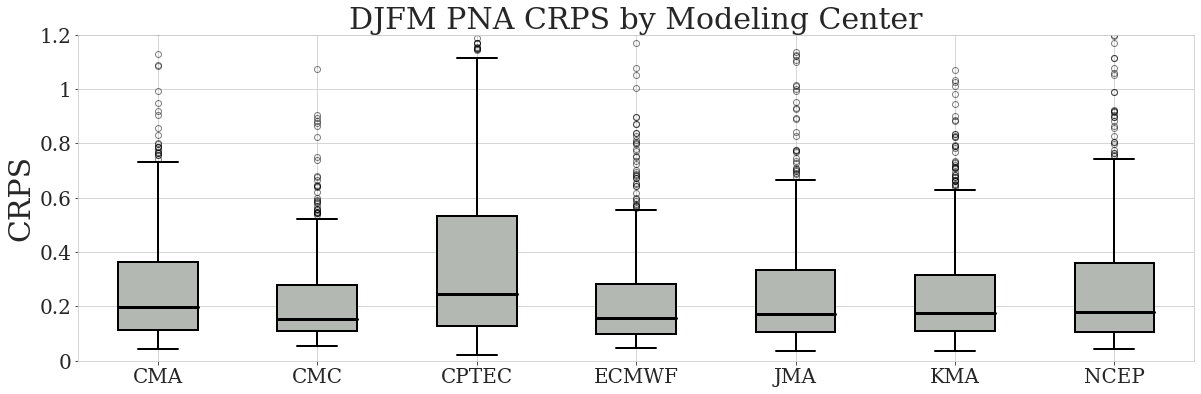

In [31]:
data_to_plot=[crpsdict['CMA'],crpsdict['CMC'],crpsdict['CPTEC'],crpsdict['ECMWF'],
              crpsdict['JMA'],crpsdict['KMA'],crpsdict['NCEP']]


fig = plt.figure(1, figsize=(20, 6))

# Create an axes instance
ax = fig.add_subplot(111)
## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='k', linewidth=2)
    # change fill color
    box.set( facecolor = [0.7,0.72,0.7] )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='k', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='k', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='k', linewidth=3)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='k', alpha=0.5)
    
plt.ylim([0,1.2])
ax.set_xticklabels(crpsdict.keys(),fontsize=20)
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1,1.2],fontsize=20)


ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.title('DJFM PNA CRPS by Modeling Center',fontsize=30)
plt.ylabel('CRPS',fontsize=30)

fname = 'CRPS_PNA_Center.png'
plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()


# Post-Process a Single Modeling Center:

In [32]:
print('correcting:',PNA_zarrs[2])
AllDat = xr.open_zarr(PNA_zarrs[2])
AllDat=AllDat.to_dataframe()

correcting: /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/PNA_CPTECzar


In [33]:
AllDat[AllDat['Forecast_Lead']==10]

,Analysis,Center,Ense,Forecast_Date,Forecast_Lead,PNA
index,,,,,,
10,0.182303,CPTEC,0,2008020112,10,-0.406646
26,0.182303,CPTEC,1,2008020112,10,-0.625988
42,0.182303,CPTEC,2,2008020112,10,-0.340697
58,0.182303,CPTEC,3,2008020112,10,-0.557336
74,0.182303,CPTEC,4,2008020112,10,-0.470365
...,...,...,...,...,...,...
170,-1.308171,CPTEC,10,2020013112,10,-1.609440
186,-1.308171,CPTEC,11,2020013112,10,-0.432712
202,-1.308171,CPTEC,12,2020013112,10,-1.655750


## Split into only the winter time and decide on a desired lead time:

In [34]:
#
leadtime=10 #days
monthz = [12,1,2,3] #month to post-process with EMOS 
AllDatLead = AllDat.loc[AllDat['Forecast_Lead']==leadtime]
#create a day,month,year column:

dayz = []
mons = []
yrs = []

for bb,dat in enumerate((AllDatLead['Forecast_Date'])):
    datetime_object = datetime.strptime(str(dat), '%Y%m%d%H')
    yrs.append(datetime_object.year)
    mons.append(datetime_object.month)
    dayz.append(datetime_object.day)
    
AllDatLead.insert(6,'day',dayz)
AllDatLead.insert(7,'month',mons)
AllDatLead.insert(8,'year',yrs)

# #select the month we'd like to post-process
if len(monthz)==1:
    AllDatMon = AllDatLead.loc[AllDatLead['month'] == monthz[0]]
else:
    AllDatMon = AllDatLead.loc[AllDatLead['month'] == monthz[0]]
    for mm in monthz[1:]:
        AllDatMon = AllDatMon.append(AllDatLead.loc[AllDatLead['month'] == mm])


#create mean and standard deviation for the Ensemble forecast: 
PNA_mean=[]
PNA_std=[]
PNA_obs=[]
For_Date=[]
yz=[]
mz=[]
dz=[]

for nn,dat in enumerate(np.unique(AllDatMon['Forecast_Date'])):
    tt = AllDatMon[AllDatMon.Forecast_Date==dat].PNA
    PNA_mean.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].PNA))
    PNA_std.append(np.std(AllDatMon[AllDatMon.Forecast_Date==dat].PNA))
    PNA_obs.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].Analysis))
    dz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].day))
    mz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].month))
    yz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].year))
    For_Date.append(dat)

    
d = {'PNA_mean': PNA_mean, 'PNA_std': PNA_std,'PNA_obs':PNA_obs,'Fore_Date':For_Date,
     'day':dz,'month':mz,'year':yz}
PNAdf  = pd.DataFrame(data=d)
PNAdf

,PNA_mean,PNA_std,PNA_obs,Fore_Date,day,month,year
0,-0.416722,0.158865,0.182303,2008020112,1.0,2.0,2008.0
1,-0.341240,0.172453,0.302933,2008020212,2.0,2.0,2008.0
2,-0.408830,0.125366,0.672903,2008020312,3.0,2.0,2008.0
3,-0.446256,0.140056,0.093351,2008020412,4.0,2.0,2008.0
4,-0.557827,0.108024,-0.076083,2008020512,5.0,2.0,2008.0
...,...,...,...,...,...,...,...
1170,-0.973474,0.427025,-0.583412,2020012712,27.0,1.0,2020.0
1171,-1.033750,0.239932,-0.781955,2020012812,28.0,1.0,2020.0
1172,-1.137990,0.285787,-0.801990,2020012912,29.0,1.0,2020.0
1173,-1.206941,0.368392,-0.656546,2020013012,30.0,1.0,2020.0


In [35]:
PNA_train = PNAdf[PNAdf.year<=2017]
PNA_validate = PNAdf[(PNAdf.year>=2018)&(PNAdf.year<2019)]
PNA_test = PNAdf[(PNAdf.year>=2019)]

In [36]:
MODpna_pred = np.transpose(np.array([PNA_test.PNA_mean,PNA_test.PNA_std]))
crps_mod= keras.backend.eval(crps_cost_function(np.expand_dims(PNA_test['PNA_obs'],axis=1),MODpna_pred))
crps_mod

0.3897994433751893

## Split: Train,Test,Validate

In [37]:
xm=np.array(PNA_train['PNA_mean'])
xs=np.array(PNA_train['PNA_std'])
y=np.array(PNA_train['PNA_obs'])

xm_v=np.array(PNA_validate['PNA_mean'])
xs_v=np.array(PNA_validate['PNA_std'])
y_v=np.array(PNA_validate['PNA_obs'])

xm_t=np.array(PNA_test['PNA_mean'])
xs_t=np.array(PNA_test['PNA_std'])
y_t=np.array(PNA_test['PNA_obs'])

## Build the EMOS System

In [38]:
emos = build_EMOS_network_keras(compile=True, optimizer='sgd', lr=0.1)
emos.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1)            2           input_5[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1)            2           input_6[0][0]                    
____________________________________________________________________________________________

## Train

In [39]:
bn=20
epcs=100
#### KERAS CALLBACKS TO ADD to Training######
filp = '/where/your/best/model/is/saved'
svbst = keras.callbacks.callbacks.ModelCheckpoint(filp, monitor='val_loss', 
                                                  verbose=1, save_best_only=True, save_weights_only=False)
#add this to the callbacks in fit function to save the best model on your personal machine. 

earlystop = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                    verbose=1, mode='auto', restore_best_weights=True) 
rdclr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, 
                                                    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

#### Fitting the Model ######
emos.fit([xm,xs],y,batch_size=bn,validation_data=[[xm_v,xs_v],y_v],epochs=epcs,callbacks=[earlystop,rdclr])

Train on 948 samples, validate on 115 samples
Epoch 1/100
948/948 [==============================] - 0s 262us/step - loss: 0.5152 - val_loss: 0.3675
Epoch 2/100
948/948 [==============================] - 0s 45us/step - loss: 0.3053 - val_loss: 0.2922
Epoch 3/100
948/948 [==============================] - 0s 44us/step - loss: 0.2924 - val_loss: 0.2869
Epoch 4/100
948/948 [==============================] - 0s 39us/step - loss: 0.2923 - val_loss: 0.2797
Epoch 5/100
948/948 [==============================] - 0s 39us/step - loss: 0.2922 - val_loss: 0.2703
Epoch 6/100
948/948 [==============================] - 0s 40us/step - loss: 0.2923 - val_loss: 0.2820
Epoch 7/100
948/948 [==============================] - 0s 40us/step - loss: 0.2921 - val_loss: 0.2777
Epoch 8/100
948/948 [==============================] - 0s 40us/step - loss: 0.2918 - val_loss: 0.2730
Epoch 9/100
948/948 [==============================] - 0s 41us/step - loss: 0.2918 - val_loss: 0.2818
Epoch 10/100
948/948 [=============

## Evaluate the EMOS correction

In [40]:
#make a prediction:
preds = emos.predict([xm_t, xs_t])

In [41]:
d = {'Forecast_Time': PNA_test.Fore_Date,'Obs': PNA_test.PNA_obs,'Emos_mean': preds[:,0],'Emos_std': preds[:,1],
    'Model_mean':PNA_test.PNA_mean,'Model_std':PNA_test.PNA_std}
results_df = pd.DataFrame(d)
#Sorting DataFrame by time and Station ID
results_df

,Forecast_Time,Obs,Emos_mean,Emos_std,Model_mean,Model_std
1063,2019010112,0.832530,0.023587,0.489124,0.122169,0.242189
1064,2019010212,0.491499,0.119813,0.597353,0.312717,0.363682
1065,2019010312,0.872529,0.132280,0.556907,0.337405,0.318279
1066,2019010412,0.822113,0.052911,0.424799,0.180236,0.169981
1067,2019010512,0.784372,0.074118,0.625572,0.222230,0.395359
...,...,...,...,...,...,...
1170,2020012712,-0.583412,-0.529704,0.653781,-0.973474,0.427025
1171,2020012812,-0.781955,-0.560143,0.487113,-1.033750,0.239932
1172,2020012912,-0.801990,-0.612783,0.527962,-1.137990,0.285787
1173,2020013012,-0.656546,-0.647603,0.601548,-1.206941,0.368392


In [42]:
crps_preds = emos.evaluate([xm_t,xs_t],y_t)
#jump through hoops to get data in the right form for loss function:
MODpna_pred = np.transpose(np.array([results_df.Model_mean,results_df.Model_std]))
crps_mod= keras.backend.eval(crps_cost_function(np.expand_dims(y_t,axis=1),MODpna_pred))

112/112 [==============================] - 0s 26us/step


In [43]:
print('Post-Processed with EMOS = CRPS:',crps_preds)
print('Raw Ensemble a Global = CRPS:',crps_mod)

Post-Processed with EMOS = CRPS: 0.31151290450777325
Raw Ensemble a Global = CRPS: 0.3897994433751893


## Try with a Neural Network

In [47]:
NN = build_NN_network_keras(compile=True, optimizer='sgd', lr=0.1)
NN.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 1)            2           input_9[0][0]                    
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 1)            2           input_10[0][0]                   
____________________________________________________________________________________________

In [48]:
bn=30
epcs=100
#### KERAS CALLBACKS TO ADD to Training######
filp = '/where/your/best/model/is/saved'
svbst = keras.callbacks.callbacks.ModelCheckpoint(filp, monitor='val_loss', 
                                                  verbose=1, save_best_only=True, save_weights_only=False)
#add this to the callbacks in fit function to save the best model on your personal machine. 

earlystop = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, 
                                                    verbose=1, mode='auto', restore_best_weights=True) 
rdclr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, 
                                                    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

#### Fitting the Model ######
NN.fit([xm,xs],y,batch_size=bn,validation_data=[[xm_v,xs_v],y_v],epochs=epcs,callbacks=[earlystop,rdclr])

Train on 948 samples, validate on 115 samples
Epoch 1/100
948/948 [==============================] - 0s 286us/step - loss: 0.3484 - val_loss: 0.3370
Epoch 2/100
948/948 [==============================] - 0s 34us/step - loss: 0.3180 - val_loss: 0.3193
Epoch 3/100
948/948 [==============================] - 0s 31us/step - loss: 0.3119 - val_loss: 0.3075
Epoch 4/100
948/948 [==============================] - 0s 30us/step - loss: 0.3105 - val_loss: 0.3126
Epoch 5/100
948/948 [==============================] - 0s 30us/step - loss: 0.3093 - val_loss: 0.2978
Epoch 6/100
948/948 [==============================] - 0s 31us/step - loss: 0.3093 - val_loss: 0.3012
Epoch 7/100
948/948 [==============================] - 0s 32us/step - loss: 0.3092 - val_loss: 0.2962
Epoch 8/100
948/948 [==============================] - 0s 29us/step - loss: 0.3094 - val_loss: 0.2960
Epoch 9/100
948/948 [==============================] - 0s 28us/step - loss: 0.3096 - val_loss: 0.3026
Epoch 10/100
948/948 [=============

In [49]:
#make a prediction:
predsE = emos.predict([xm_t, xs_t])
preds = NN.predict([xm_t, xs_t])

d = {'Forecast_Time': PNA_test.Fore_Date,'Obs': PNA_test.PNA_obs,'NN_mean': preds[:,0],'NN_std': preds[:,1],
    'EMOS_mean':predsE[:,0],'EMOS_std':predsE[:,1],'Model_mean':PNA_test.PNA_mean,'Model_std':PNA_test.PNA_std}
results_df = pd.DataFrame(d)
#Sorting DataFrame by time and Station ID
results_df

,Forecast_Time,Obs,NN_mean,NN_std,EMOS_mean,EMOS_std,Model_mean,Model_std
1063,2019010112,0.832530,-0.042445,-0.073034,0.023587,0.489124,0.122169,0.242189
1064,2019010212,0.491499,0.130616,0.227740,0.119813,0.597353,0.312717,0.363682
1065,2019010312,0.872529,0.154615,0.271036,0.132280,0.556907,0.337405,0.318279
1066,2019010412,0.822113,0.019139,0.036770,0.052911,0.424799,0.180236,0.169981
1067,2019010512,0.784372,0.041196,0.070063,0.074118,0.625572,0.222230,0.395359
...,...,...,...,...,...,...,...,...
1170,2020012712,-0.583412,-0.372844,-0.657271,-0.529704,0.653781,-0.973474,0.427025
1171,2020012812,-0.781955,-0.357693,-0.626190,-0.560143,0.487113,-1.033750,0.239932
1172,2020012912,-0.801990,-0.361406,-0.633808,-0.612783,0.527962,-1.137990,0.285787
1173,2020013012,-0.656546,-0.368096,-0.647531,-0.647603,0.601548,-1.206941,0.368392


In [50]:
crps_preds = NN.evaluate([xm_t,xs_t],y_t)
#jump through hoops to get data in the right form for loss function:
MODpna_pred = np.transpose(np.array([results_df.Model_mean,results_df.Model_std]))
crps_mod= keras.backend.eval(crps_cost_function(np.expand_dims(y_t,axis=1),MODpna_pred))

112/112 [==============================] - 0s 38us/step


In [51]:
print('Post-Processed with NN = CRPS:',crps_preds)
print('Raw Ensemble a Global = CRPS:',crps_mod)

Post-Processed with NN = CRPS: 0.31972749318395344
Raw Ensemble a Global = CRPS: 0.3897994433751893


In [52]:
#EMOS vs. RAW vs. NN
crps_m = []
crps_p = []
crps_e = []

for nn in range(len(results_df)):
    MODpna_pred = (np.array([results_df.Model_mean.iloc[nn],results_df.Model_std.iloc[nn]]))
    crps_mod= crps_(np.expand_dims([results_df['Obs'].iloc[nn]],axis=1),
                                                np.transpose(np.expand_dims(np.array(MODpna_pred),axis=1)))
    
    crps_m.append(crps_mod)
    
    MODpna_pred = (np.array([results_df.NN_mean.iloc[nn],results_df.NN_std.iloc[nn]]))
    crps_pp=crps_(np.expand_dims([results_df['Obs'].iloc[nn]],axis=1),
                                                np.transpose(np.expand_dims(np.array(MODpna_pred),axis=1)))
    crps_p.append(crps_pp)
    
    MODpna_pred = (np.array([results_df.EMOS_mean.iloc[nn],results_df.EMOS_std.iloc[nn]]))
    crps_ee= crps_(np.expand_dims([results_df['Obs'].iloc[nn]],axis=1),
                                                np.transpose(np.expand_dims(np.array(MODpna_pred),axis=1)))
    crps_e.append(crps_ee)
    

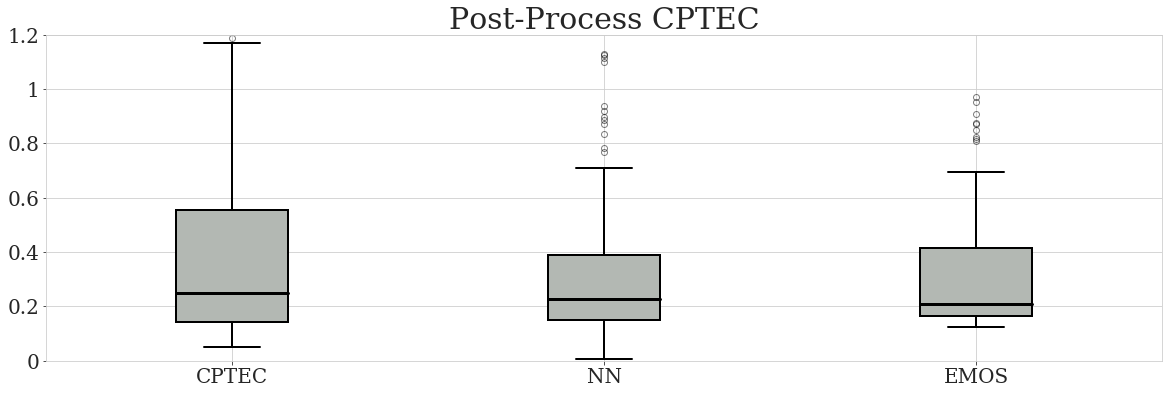

In [53]:
data_to_plot=[crps_m,crps_p,crps_e]


fig = plt.figure(1, figsize=(20, 6))

# Create an axes instance
ax = fig.add_subplot(111)
## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='k', linewidth=2)
    # change fill color
    box.set( facecolor = [0.7,0.72,0.7] )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='k', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='k', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='k', linewidth=3)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='k', alpha=0.5)
    
plt.ylim([0,1.2])
ax.set_xticklabels(['CPTEC','NN','EMOS'],fontsize=20)
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1,1.2],fontsize=20)


ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.title('Post-Process CPTEC',fontsize=30)
plt.show()
